## Visualization of the distribution of entropy scores of predictions for a model

In [20]:
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn as skl

from mylib import class_distributions
from mylib import data_selection
from mylib import helper_funcs

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
data_folder = Path("../../data/DryBeanDataset/")
image_folder = Path("../../images/DryBeanDataset/data_selection_visualization/")
file_to_open = data_folder / "Dry_Bean_Dataset.xlsx"

In [22]:
# read and prepare data
data = pd.read_excel(file_to_open)

labels_dict = {key:value for (value,key) in enumerate(data["Class"].unique())}
class_names = np.array(list(labels_dict.keys()))
data["Class"] = data["Class"].map(labels_dict)

# need feature matrix X and labels labels for xgboost
labels = data["Class"]
X = data.drop(["Class"],axis=1,inplace=False)

In [23]:
# params for XGBoost
num_labels = len(labels.unique())
num_round = 100
max_depth = 3
eta = .1

# parameters for full model
param_full = {'max_depth': max_depth,
              'eta': eta,
              'objective': 'multi:softprob',
              "num_class": num_labels}
param_full['nthread'] = 4
param_full['eval_metric'] = 'mlogloss'

In [24]:
# split data into train- and test-data
seed = np.random.randint(0,100)
X_train_full, X_test_full, y_train_full, y_test_full = skl.model_selection.train_test_split(X,
                                                                                            labels,
                                                                                            test_size=.2,
                                                                                            random_state=seed)

dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full)
dtest_full = xgb.DMatrix(X_test_full, label=y_test_full)

evallist_full = [(dtrain_full, 'train'), (dtest_full, 'eval')]


# training a model with all the training data
bst_full = xgb.train(param_full,
                     dtrain_full,
                     num_round,
                     evals=evallist_full,
                     verbose_eval=False)

In [25]:
print(skl.metrics.accuracy_score(np.argmax(bst_full.predict(dtest_full), axis=1),
                                                     y_test_full))

0.9331619537275064


In [26]:
dfull = xgb.DMatrix(X, label=labels)

predictions = bst_full.predict(dfull)
entropy_scores = data_selection.entropy(predictions)

In [27]:
predictions.max(axis=1)

array([0.5100912 , 0.9836193 , 0.89155596, ..., 0.6429364 , 0.7723671 ,
       0.7605135 ], dtype=float32)

In [28]:
data_selection.entropy(predictions[:2])

array([1.0847365 , 0.14173847], dtype=float32)

In [29]:
max_entropy = max(entropy_scores)
min_entropy = min(entropy_scores)

# 5 entropy bins
num_bins = 5
entropy_bins = (max_entropy-min_entropy)/num_bins

entropy_labels = np.zeros(len(X))

for i in range(1,num_bins):
    idx=np.argwhere(entropy_scores >= min_entropy+i*entropy_bins)
    entropy_labels[idx]+=1

In [30]:
# normalize
data_normal = (X-X.min())/(X.max()-X.min())

# PCA
pca = skl.decomposition.PCA(n_components=2)
pca_features = pca.fit_transform(data_normal)

pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])

pca_df["Class"]= labels

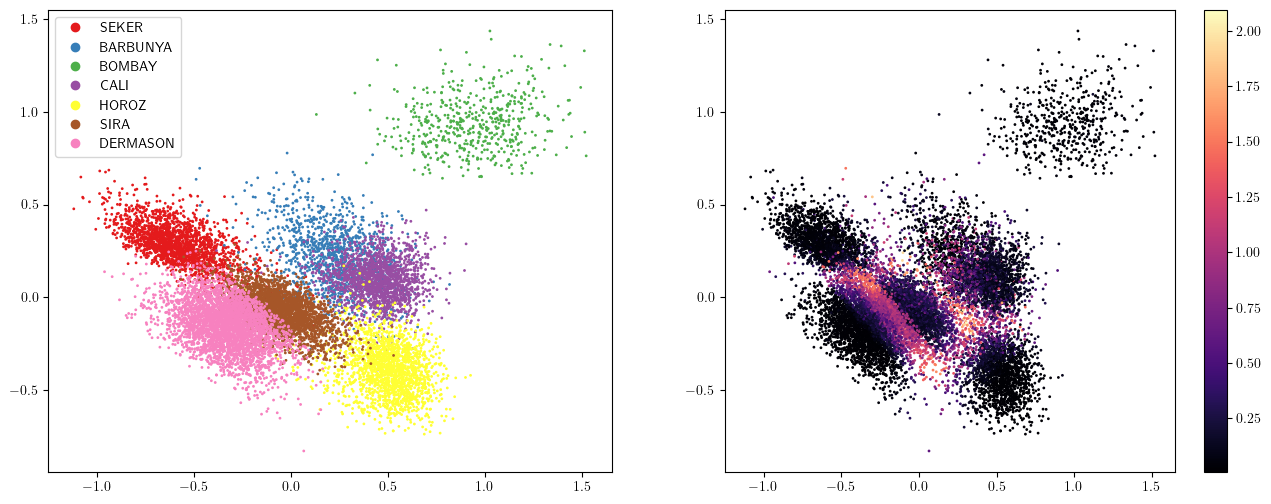

In [32]:
# visualize entropy distribution on data points

#legend_labels = [f'{class_idx}' for class_idx in labels_small.unique()]
legend_labels = list(class_names)
#entropy_legend_labels = [f'{entropy_bin}' for entropy_bin in set(entropy_labels)]
#entropy_legend_labels = ['0.0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1.0']

fig, axs = plt.subplots(1,2,figsize=(16,6))

scatter = axs[0].scatter(pca_features[:,0], pca_features[:,1], s=1, c=labels, cmap='Set1', vmin=0, vmax=7);
axs[0].legend(handles = scatter.legend_elements()[0], labels=legend_labels);

scatter = axs[1].scatter(pca_features[:,0], pca_features[:,1], s=1, c=entropy_scores, cmap='magma');
#axs[1].legend(handles = scatter.legend_elements()[0], labels=entropy_legend_labels, title="entropy score");
fig.colorbar(scatter);

plt.savefig(image_folder / 'entropy_distribution.jpg')